Trial 30 Complete [00h 00m 06s]
val_loss: 0.009919228963553905

Best val_loss So Far: 0.003494557458907366
Total elapsed time: 00h 02m 12s


Best Hyperparameters: {'units': 50, 'learning_rate': 0.009471858758984132, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R^2 Score: 0.902
RMSE: 1.652
MAE: 1.221
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━

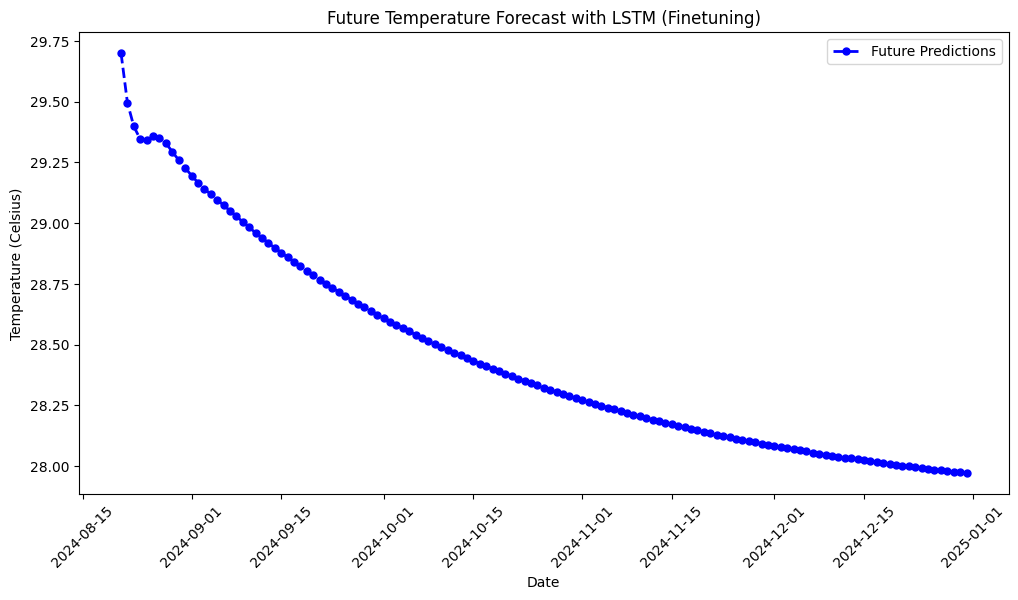

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import kerastuner as kt
import shutil

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
file_path = '../dataset/Data.csv'  # Adjust the path to your dataset
data = pd.read_csv(file_path)

# Prepare the data for LSTM
data['ds'] = pd.to_datetime(data['datetime'], format='%m/%d/%Y')  # Convert datetime
data.set_index('ds', inplace=True)  # Set datetime as index

# Use temperature ('temp') as the target variable
temperature = data['temp'].values.reshape(-1, 1)  # Reshape 'temp' for scaling

# Step 1: Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize the scaler
scaled_data = scaler.fit_transform(temperature)  # Scale the temperature data

# Step 2: Create a dataset with time steps
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10  # Define the time step for creating the dataset
X, y = create_dataset(scaled_data, time_step)  # Create the dataset
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape X to be [samples, time steps, features]

# Step 3: Split the data into training and testing sets
split_index = int(len(X) * 0.8)  # Define the split index
X_train, X_test = X[:split_index], X[split_index:]  # Split features
y_train, y_test = y[:split_index], y[split_index:]  # Split target values

# Step 4: Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()
    # Add LSTM layers with hyperparameters for units
    model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=hp.Int('units', min_value=10, max_value=100, step=10), return_sequences=False))
    model.add(Dense(1))  # Output layer
    # Compile the model with Adam optimizer and mean squared error loss
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss='mean_squared_error')
    return model

# Step 5: Set up and run the hyperparameter tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='my_dir',  # Directory for tuning trials
    project_name='weather_forecast'  # Project name
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

# Step 6: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hp.values}")
model_path = 'best_weather_model.h5'
best_model.save(model_path)
best_model = load_model(model_path)

# Step 7: Evaluate the model
predictions = best_model.predict(X_test)  # Make predictions on the test set
predictions = scaler.inverse_transform(predictions)  # Inverse transform the predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform the actual values

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))  # Calculate RMSE
mae = mean_absolute_error(y_test_inv, predictions)  # Calculate MAE
r2 = r2_score(y_test_inv, predictions)  # Calculate R² Score
print(f"R^2 Score: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Step 8: Generate future predictions
future_dates = pd.date_range(start='2024-08-21', end='2024-12-31', freq='D')  # Define future dates
future_steps = len(future_dates)

last_sequence = scaled_data[-time_step:]  # Initialize the last sequence
future_predictions = []

# Generate predictions for future dates
for _ in range(future_steps):
    last_sequence = last_sequence.reshape((1, time_step, 1))  # Reshape for prediction
    future_pred = best_model.predict(last_sequence)  # Predict future value
    future_predictions.append(future_pred[0, 0])  # Append prediction
    future_pred_reshaped = future_pred.reshape(1, 1, 1)
    last_sequence = np.concatenate((last_sequence[:, 1:, :], future_pred_reshaped), axis=1)  # Update last sequence

# Step 9: Create a DataFrame for future results and save to CSV
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))  # Inverse transform future predictions
future_results_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Temperature': future_predictions_inv.flatten()
})

# Save future predictions to CSV
future_results_df.to_csv('future_weather_predictions_lstm_finetuning.csv', index=False)
print("Future weather predictions saved to 'future_weather_predictions_lstm_finetuning.csv'")

# Step 10: Plot only the future predicted temperatures
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions_inv, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=5, label='Future Predictions')  # Plot future predictions
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.title('Future Temperature Forecast with LSTM (Finetuning)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Cleanup: Remove the directory containing the trials
shutil.rmtree('my_dir')
